In [1]:
#imports
try:
    from google.colab import drive
    #mount drive, set base path
    drive.mount("/gdrive")
    base_path = '/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites'
except:
    base_path = '../'
from pathlib import Path
import matplotlib.pyplot as plt
import random
from random import randint, choice

import time

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

from tqdm.auto import tqdm
import numpy as np
from PIL import Image

import copy

In [2]:
import neptune.new as neptune
import neptune.new.integrations.optuna as optuna_utils

In [3]:
torch.cuda.is_available()

True

In [4]:
#utility functions for:
# setting the seed
# ensuring randomness of worker in data loader (overkill?)
# setting the device based on GPU availability

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
#dataset paths
#set these paths and file names depending on where you are and which labels you are using

data_path = Path(base_path).joinpath('data/')
train_images_path = Path(data_path).joinpath('training_images_rand4_unique.npy')
train_labels_path = Path(data_path).joinpath('training_objcounts_rand4_unique.npy')
val_images_path = Path(data_path).joinpath('validation_images_rand4_unique.npy')
val_labels_path = Path(data_path).joinpath('validation_objcounts_rand4_unique.npy')

#get image area
train_imgarea_path = Path(data_path).joinpath('training_imgareas_rand4_unique.npy')
val_imgarea_path = Path(data_path).joinpath('validation_imgareas_rand4_unique.npy')

In [6]:
#load the numpy dataset files
train_images = np.load(train_images_path).astype(float)
train_labels = torch.tensor(np.load(train_labels_path).astype(float))
val_images = np.load(val_images_path).astype(float)
val_labels = torch.tensor(np.load(val_labels_path).astype(float))

#load image area files
train_imgarea = np.load(train_imgarea_path).astype(float)
val_imgarea = np.load(val_imgarea_path).astype(float)

In [7]:
# change labels so that they start at 0
# TODO this is only valid for counts - so we need a flag for this or change the generator or dataloader appropriately
train_labels = (train_labels)
val_labels = (val_labels)
print(train_labels, val_labels)

tensor([3., 2., 2.,  ..., 3., 1., 2.], dtype=torch.float64) tensor([2., 1., 3.,  ..., 1., 4., 4.], dtype=torch.float64)


Text(0.5, 1.0, 'object area: tensor(4., dtype=torch.float64)')

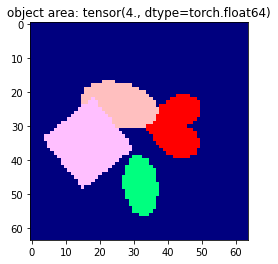

In [8]:
#examine data
idx = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[idx])
plt.title('object area: ' + str(train_labels[idx]))

## Prepare dataloaders for cnn

In [9]:
#define the dataset class for our data for use by the dataloader
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, images, labels, transform=None, target_transform=None):
        # assert all(tensors[0].size[0] == tensor.size[0] for tensor in tensors)
        self.images = images
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
          x = self.transform(x)

        y = self.img_labels[index]
        if self.target_transform:
          y = self.target_transform(y)

        return x.float(), y.float(), index

    def __len__(self):
        return len(self.img_labels)

In [10]:
#instantiate the dataset
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data =  CustomTensorDataset(train_images, train_labels, transform=train_transform)
val_data = CustomTensorDataset(val_images,val_labels,transform=train_transform)

In [11]:
#instantiate the dataloaders

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

BATCH_SIZE = 128  # number of examples per minibatch

train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           num_workers=12,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_data,
                                         shuffle=True,
                                         batch_size=BATCH_SIZE,
                                         num_workers=12,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Random seed 2021 has been set.
GPU is enabled in this notebook.


## CNN model for regression

In [12]:
# Create a sample network
class conv_net(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [13]:
# Create a sample network
class conv_net1(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [14]:
# Create a sample network
class conv_net2(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

Training and testing functions

In [15]:
def calc_error(output,target):
    return np.abs(output-target)/target

In [20]:
#define the train and test loops, and a wrapper that will call them to train and collect validation stats

def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
    """
    Trains the current inpur model using the data
    from Train_loader and Updates parameters for a single pass
    """
    device = args['device']
    model.train()
    for batch_idx, (data, target, index) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()

    return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
    """
    Tests the current Model
    """
    model.eval()
    test_loss = 0
    perc_error = 0
    
    with torch.no_grad():
        for data, target, index in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            perc_error += np.sum(calc_error(output.cpu().detach().numpy(),target.cpu().detach().numpy()))
    test_loss /= len(test_loader.dataset)
    perc_error /= len(test_loader.dataset)
    return test_loss, perc_error


# def main(args, model, train_loader, val_loader,
#          reg_function1=None, reg_function2=None):
#   """
#   Trains the model with train_loader and tests the learned model using val_loader
#   """

#   device = args['device']

#   model = model.to(device)
#   optimizer = optim.SGD(model.parameters(), lr=args['lr'],
#                         momentum=args['momentum'])

#   val_loss_list, train_loss_list,param_norm_list = [], [], []
#   for epoch in tqdm(range(args['epochs'])):
#     trained_model = train(args, model, train_loader, optimizer,
#                           reg_function1=reg_function1,
#                           reg_function2=reg_function2)
#     train_loss = test(trained_model, train_loader, device=device)
#     val_loss = test(trained_model, val_loader, device=device)
#     print(train_loss, val_loss)
#     # param_norm = calculate_frobenius_norm(trained_model)
#     train_loss_list.append(train_loss)
#     val_loss_list.append(val_loss)
#     # param_norm_list.append(param_norm)

#   return val_acc_list, train_acc_list, trained_model

def early_stopping_main(args, model, train_loader, val_loader, criterion, reg_function1=None, reg_function2=None):
    device = args['device']
    model = model.to(device)
#     optimizer = optim.SGD(model.parameters(),
#                         lr=args['lr'],
#                         momentum=args['momentum'])
    kwargs = {'params': model.parameters(), 'lr': args['lr']}
    if args['optimizer'] in ['SGD', 'RMSprop']: kwargs['momentum'] = args['momentum']
    optimizer = getattr(optim, args['optimizer'])(**kwargs)
    best_acc = float('inf')
    best_epoch = 0

    # Number of successive epochs that you want to wait before stopping training process
    patience = 30

    # Keps track of number of epochs during which the val_acc was less than best_acc
    wait = 0

    val_acc_list, train_acc_list, val_error_list, train_error_list = [], [], [], []
    for epoch in tqdm(range(args['epochs'])):

        # train the model
        trained_model = train(args, model, train_loader, optimizer,
                              reg_function1=reg_function1,
                              reg_function2=reg_function2,
                              criterion=criterion)

        # calculate training accuracy
        train_loss, train_perc_error = test(trained_model, train_loader, criterion=criterion, device=device)

        # calculate validation accuracy
        val_loss, val_perc_error = test(trained_model, val_loader, criterion=criterion, device=device)
        best_model = None
        if (val_perc_error < best_acc):
            best_acc = val_perc_error
            best_epoch = epoch
            best_model = copy.deepcopy(trained_model)
            wait = 0
        else:
            wait += 1

        if (wait > patience):
            print(f'early stopped on epoch: {epoch}')
            break

        train_acc_list.append(train_loss)
        val_acc_list.append(val_loss)
        train_error_list.append(train_perc_error)
        val_error_list.append(val_perc_error)
#         print(train_loss, val_loss, train_perc_error, val_perc_error)
    #save the model
#     if('checkpoint_path' in args):
#         torch.save({
#           'model_state_dict': best_model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict()
#           }, args['checkpoint_path'])

    return val_acc_list, train_acc_list, train_error_list, val_error_list, best_model, best_epoch


In [21]:
def optuna_objective(trial):
    cnn_lr = trial.suggest_float('cnn_lr', 1e-6, 1e2, log=True)
    cnn_momentum = trial.suggest_float('cnn_momentum', 0.001, 1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    args = {
        'optimizer': optimizer_name,
        'epochs': 200,
        'lr': cnn_lr,
        'momentum': cnn_momentum,
        'device': DEVICE,
        'checkpoint_path': './simpleCNN.pt'
        }
    
    set_seed(seed=SEED)
    model = conv_net2()
    val_loss_pure, train_loss_pure, train_error_list, val_error_list, model, best_epoch= early_stopping_main(args=args,
                                                                model=model,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                criterion=F.mse_loss)
    score = min(val_error_list)
    return score



In [22]:
NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhYTk4Zjg0Zi1lYjNhLTRiNGMtODdhMy0zMjEyMjEzYWY4MjEifQ=='


run = neptune.init(project='kkarbasi/nma-dl',
             api_token=NEPTUNE_API_TOKEN,
             tags=['regression', 'cnn']
             )

run['optimizer/hyperparameters'] = 'optuna'

neptune_callback = optuna_utils.NeptuneCallback(run,
                                               log_plot_contour=False,  # do not create/log plot_slice
                                               )

https://app.neptune.ai/kkarbasi/nma-dl/e/NMAD-4
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(optuna_objective, n_trials=2000, callbacks=[neptune_callback])

[I 2021-08-17 20:23:58,140] A new study created in memory with name: no-name-ba62a76f-7835-4f48-aebe-6b5a25b02970


Random seed 2021 has been set.


[I 2021-08-17 20:32:01,750] Trial 0 finished with value: 0.29181223402023315 and parameters: {'cnn_lr': 1.4002722766788721e-05, 'cnn_momentum': 0.008719759210970733, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.29181223402023315.


early stopped on epoch: 50

Random seed 2021 has been set.


[I 2021-08-17 20:45:37,441] Trial 1 finished with value: 0.12014615125656128 and parameters: {'cnn_lr': 0.028703641593234033, 'cnn_momentum': 0.042341783819905894, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.12014615125656128.


early stopped on epoch: 85

Random seed 2021 has been set.


[I 2021-08-17 21:17:06,840] Trial 2 finished with value: 0.08149098286628723 and parameters: {'cnn_lr': 0.00038413048078536063, 'cnn_momentum': 0.04048300142402773, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 198

Random seed 2021 has been set.


[W 2021-08-17 21:22:01,756] Trial 3 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-17 21:27:06,384] Trial 4 finished with value: 0.529821530342102 and parameters: {'cnn_lr': 0.008527572362756499, 'cnn_momentum': 0.42631997805147515, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 31

Random seed 2021 has been set.


[I 2021-08-17 21:45:37,845] Trial 5 finished with value: 0.09388551003932953 and parameters: {'cnn_lr': 0.0008188558457252952, 'cnn_momentum': 0.005175300382580256, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 116

Random seed 2021 has been set.


[I 2021-08-17 21:51:29,803] Trial 6 finished with value: 0.28903490381240843 and parameters: {'cnn_lr': 4.341182544182009e-05, 'cnn_momentum': 0.10710799096316742, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 36

Random seed 2021 has been set.


[W 2021-08-17 21:56:22,785] Trial 7 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-17 22:27:53,232] Trial 8 finished with value: 0.44092354803085326 and parameters: {'cnn_lr': 1.7323974638597763e-06, 'cnn_momentum': 0.0018756304646708355, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.08149098286628723.



Random seed 2021 has been set.


[W 2021-08-17 22:32:47,941] Trial 9 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[W 2021-08-17 22:37:41,747] Trial 10 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-17 22:47:50,242] Trial 11 finished with value: 1554555175039926.2 and parameters: {'cnn_lr': 0.41921377880572924, 'cnn_momentum': 0.0012050070204353489, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 63

Random seed 2021 has been set.


[I 2021-08-17 23:00:03,080] Trial 12 finished with value: 7.095403101216928e+16 and parameters: {'cnn_lr': 0.8136507300588016, 'cnn_momentum': 0.004306052602972765, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 76

Random seed 2021 has been set.


[I 2021-08-17 23:06:24,502] Trial 13 finished with value: 4.043839449895159e+17 and parameters: {'cnn_lr': 10.319965776054001, 'cnn_momentum': 0.12472937038489385, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 39

Random seed 2021 has been set.


[I 2021-08-17 23:13:05,917] Trial 14 finished with value: 0.21480720300674438 and parameters: {'cnn_lr': 0.0004995573168811557, 'cnn_momentum': 0.9307069278508754, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 41

Random seed 2021 has been set.


[I 2021-08-17 23:29:15,355] Trial 15 finished with value: 0.09510746126174927 and parameters: {'cnn_lr': 0.0011714183782788935, 'cnn_momentum': 0.011338110504027577, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 101

Random seed 2021 has been set.


[I 2021-08-17 23:55:26,318] Trial 16 finished with value: 0.08540155419111252 and parameters: {'cnn_lr': 0.00023711054676159876, 'cnn_momentum': 0.032276505813719214, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 164

Random seed 2021 has been set.


[I 2021-08-18 00:01:48,101] Trial 17 finished with value: 0.30819234466552736 and parameters: {'cnn_lr': 4.077974167475901e-05, 'cnn_momentum': 0.024358142834056833, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 39

Random seed 2021 has been set.


[I 2021-08-18 00:07:40,972] Trial 18 finished with value: 0.38578549690246583 and parameters: {'cnn_lr': 0.031085492723859243, 'cnn_momentum': 0.04939912497011412, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 36

Random seed 2021 has been set.


[I 2021-08-18 00:39:28,996] Trial 19 finished with value: 0.08941307747364044 and parameters: {'cnn_lr': 0.00016417861589264207, 'cnn_momentum': 0.13361145924704457, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.



Random seed 2021 has been set.


[I 2021-08-18 01:01:19,660] Trial 20 finished with value: 0.3089052487373352 and parameters: {'cnn_lr': 2.378553986558376e-06, 'cnn_momentum': 0.018519803868571657, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 137

Random seed 2021 has been set.


[I 2021-08-18 01:08:05,995] Trial 21 finished with value: 0.22192607803344727 and parameters: {'cnn_lr': 0.004112033814970957, 'cnn_momentum': 0.2935463734424774, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 42

Random seed 2021 has been set.


[I 2021-08-18 01:39:45,777] Trial 22 finished with value: 12868196773763.482 and parameters: {'cnn_lr': 0.18486194194289346, 'cnn_momentum': 0.05852437206773959, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.



Random seed 2021 has been set.


[I 2021-08-18 01:47:12,102] Trial 23 finished with value: 0.3082867311477661 and parameters: {'cnn_lr': 1.643952553879589e-05, 'cnn_momentum': 0.014333845794001305, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 46

Random seed 2021 has been set.


[W 2021-08-18 01:52:05,544] Trial 24 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-18 02:19:56,079] Trial 25 finished with value: 0.26806354808807376 and parameters: {'cnn_lr': 0.00019529667179950846, 'cnn_momentum': 0.08250894135767346, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 176

Random seed 2021 has been set.


[I 2021-08-18 02:51:28,758] Trial 26 finished with value: 0.08425079388618469 and parameters: {'cnn_lr': 0.00018091302168676119, 'cnn_momentum': 0.2878986382142009, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.



Random seed 2021 has been set.


[I 2021-08-18 03:07:57,069] Trial 27 finished with value: 0.15182479040622712 and parameters: {'cnn_lr': 0.0025562540328393944, 'cnn_momentum': 0.2738513676320113, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 103

Random seed 2021 has been set.


[I 2021-08-18 03:29:38,499] Trial 28 finished with value: 0.09011095099449158 and parameters: {'cnn_lr': 0.00020107077209394403, 'cnn_momentum': 0.7377849478179299, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 136

Random seed 2021 has been set.


[I 2021-08-18 03:37:25,168] Trial 29 finished with value: 0.3118127678871155 and parameters: {'cnn_lr': 1.3647668690307785e-05, 'cnn_momentum': 0.03066321768955557, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 48

Random seed 2021 has been set.


[W 2021-08-18 03:42:19,674] Trial 30 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-18 03:47:51,549] Trial 31 finished with value: 0.2937905571460724 and parameters: {'cnn_lr': 7.079748729254634e-05, 'cnn_momentum': 0.2083182618559716, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 34

Random seed 2021 has been set.


[W 2021-08-18 03:52:46,521] Trial 32 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-18 04:03:51,630] Trial 33 finished with value: 0.3074975233078003 and parameters: {'cnn_lr': 4.044087720841188e-06, 'cnn_momentum': 0.46221737617980313, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 69

Random seed 2021 has been set.


[I 2021-08-18 04:09:33,811] Trial 34 finished with value: 0.4270105896472931 and parameters: {'cnn_lr': 0.03923707526575231, 'cnn_momentum': 0.007598351167520523, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 35

Random seed 2021 has been set.


[I 2021-08-18 04:30:39,038] Trial 35 finished with value: 0.11153480898141861 and parameters: {'cnn_lr': 0.0015194730788966827, 'cnn_momentum': 0.071453344251569, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 132

Random seed 2021 has been set.


[I 2021-08-18 04:47:28,574] Trial 36 finished with value: 0.2713128316164017 and parameters: {'cnn_lr': 0.00036611805355977605, 'cnn_momentum': 0.18968599024235977, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 105

Random seed 2021 has been set.


[I 2021-08-18 04:55:54,757] Trial 37 finished with value: 0.29468222675323485 and parameters: {'cnn_lr': 1.1376046467396065e-05, 'cnn_momentum': 0.030776893376635507, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 52

Random seed 2021 has been set.


[I 2021-08-18 05:27:33,011] Trial 38 finished with value: 0.08458655017018318 and parameters: {'cnn_lr': 0.0002518449921175314, 'cnn_momentum': 0.13079732308724543, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.



Random seed 2021 has been set.


[I 2021-08-18 05:33:05,378] Trial 39 finished with value: 0.2970850176334381 and parameters: {'cnn_lr': 0.00010323783582182122, 'cnn_momentum': 0.0441505922542062, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 34

Random seed 2021 has been set.


[I 2021-08-18 05:39:54,664] Trial 40 finished with value: 0.3113045163154602 and parameters: {'cnn_lr': 0.01056760901974216, 'cnn_momentum': 0.09196698890780966, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 42

Random seed 2021 has been set.


[I 2021-08-18 05:45:55,340] Trial 41 finished with value: 0.34144032299518584 and parameters: {'cnn_lr': 0.006979144626593034, 'cnn_momentum': 0.5324643086879854, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 37

Random seed 2021 has been set.


[I 2021-08-18 06:09:21,270] Trial 42 finished with value: 0.09158023988008498 and parameters: {'cnn_lr': 0.0007400841391464476, 'cnn_momentum': 0.1859992673752836, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 147

Random seed 2021 has been set.


[W 2021-08-18 06:14:15,292] Trial 43 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-18 06:45:45,115] Trial 44 finished with value: 0.30805520982742307 and parameters: {'cnn_lr': 2.8338477702501358e-05, 'cnn_momentum': 0.3312619167130039, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.08149098286628723.



Random seed 2021 has been set.


[I 2021-08-18 06:58:17,564] Trial 45 finished with value: 0.3080972615242004 and parameters: {'cnn_lr': 5.493037222857046e-06, 'cnn_momentum': 0.01965536777357957, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 78

Random seed 2021 has been set.


[I 2021-08-18 07:18:15,084] Trial 46 finished with value: 0.10707218341827393 and parameters: {'cnn_lr': 0.00031799256478993207, 'cnn_momentum': 0.14554907818368398, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 125

Random seed 2021 has been set.


[W 2021-08-18 07:23:09,391] Trial 47 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[W 2021-08-18 07:28:03,855] Trial 48 failed, because the objective function returned nan.


early stopped on epoch: 30

Random seed 2021 has been set.


[I 2021-08-18 07:33:45,741] Trial 49 finished with value: 0.2966042710542679 and parameters: {'cnn_lr': 7.272961975734947e-05, 'cnn_momentum': 0.003226190373028227, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.08149098286628723.


early stopped on epoch: 35

Random seed 2021 has been set.


In [ ]:
run.stop()

In [39]:
# set_seed(seed=SEED)
# model = conv_net2()
# model = model.to(DEVICE)

# args = {'dampening': 0,
#     'lr': 4.891929616734601e-06,
#     'momentum': 8.283341823460766,
#     'nesterov': False,
#     'weight_decay': 0}
# args = {
#     'lr': 15.474751597802834,
# }

# optimizer = optim.Adam(model.parameters(),
#     **args
# )

# args.update({
#     'epochs': 2,
#     'device': DEVICE,
#     'checkpoint_path': './simpleCNN.pt'
#     })

# args

# trained_model = train(args, model, train_loader, optimizer,
#                       reg_function1=None,
#                       reg_function2=None,
#                       criterion=F.mse_loss)

# train_loss, train_perc_error = test(trained_model, train_loader, criterion=F.mse_loss, device=DEVICE)

# len(train_loader.dataset)

# criterion=F.mse_loss

# trained_model.eval()
# test_loss = 0
# perc_error = 0
# for data, target, index in train_loader:
#     data, target = data.to(DEVICE), target.to(DEVICE)
#     output = trained_model(data)
#     test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
#     perc_error += np.sum(calc_error(output.cpu().detach().numpy(),target.cpu().detach().numpy()))

# output = trained_model(data)

# target

# output

# perc_error /= len(train_loader.dataset)

# perc_error

# train_loss

Random seed 2021 has been set.


## Analyze trained models

In [16]:
model_path = Path(base_path).joinpath('models/')
model1_path = Path(model_path).joinpath('cnn_reg_objarea_lr0.005_mmt0.8.pt')
model2_path = Path(model_path).joinpath('cnn2_reg_objarea_lr0.01_mmt0.8.pt')
model3_path = Path(model_path).joinpath('cnn3_reg_objarea_lr0.01_mmt0.8.pt')
model4_path = Path(model_path).joinpath('cnn3_reg_imgarea_lr0.01_mmt0.8.pt')
model5_path = Path(model_path).joinpath('cnn_reg_objcount_lr0.001_mmt0.8.pt')

In [33]:
model1 = conv_net()
model_state_dict = torch.load(model5_path)['model_state_dict']
model1.load_state_dict(model_state_dict)

<All keys matched successfully>

In [18]:
val_loader = torch.utils.data.DataLoader(val_data,
                                         shuffle=True,
                                         batch_size=200,
                                         num_workers=12,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

In [22]:
data,target,index = next(iter(val_loader))
# data,target = data.to(DEVICE),target.to(DEVICE)

In [23]:
output = model1(data)

Text(0, 0.5, 'predicted object area')

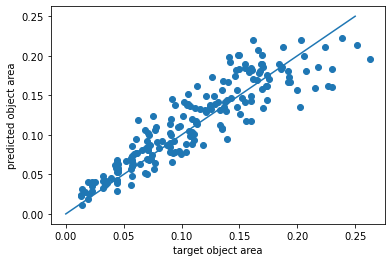

In [24]:
plt.scatter(target.cpu().detach().numpy(),output.cpu().detach().numpy())
plt.plot(np.linspace(0,0.25,10),np.linspace(0,0.25,10))
plt.xlabel('target object area')
plt.ylabel('predicted object area')

In [25]:
perc_occluded = val_imgarea/val_labels.numpy()

Text(0, 0.5, 'Percent error of area estimation')

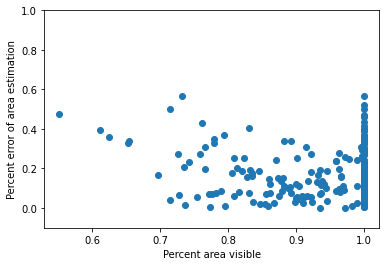

In [27]:
plt.scatter(perc_occluded[index], calc_error(target.cpu().detach().numpy(),output.cpu().detach().numpy()))
# plt.plot(np.linspace(0,0.25,10),np.linspace(0,0.25,10))
plt.ylim(-0.1,1)
plt.xlabel('Percent area visible')
plt.ylabel('Percent error of area estimation')

Text(0, 0.5, 'Predicted area - target area')

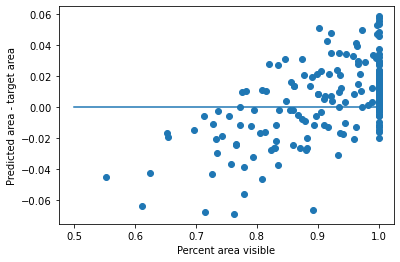

In [29]:
plt.scatter(perc_occluded[index],output.cpu().detach().numpy()- target.cpu().detach().numpy())
plt.plot(np.linspace(0.5,1,10),np.zeros(10))
# plt.ylim(-0.1,1)
plt.xlabel('Percent area visible')
plt.ylabel('Predicted area - target area')

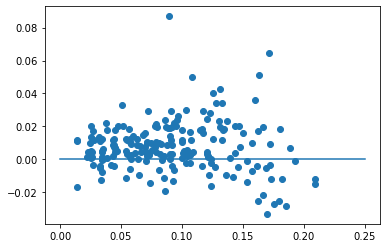

In [29]:
plt.scatter(target.cpu().detach().numpy(), output.cpu().detach().numpy()- target.cpu().detach().numpy())
plt.plot(np.linspace(0,0.25,10),np.zeros(10))
# plt.ylim(-0.1,1)

In [30]:
np.mean(calc_error(target.cpu().detach().numpy(),output.cpu().detach().numpy()))

0.18312347

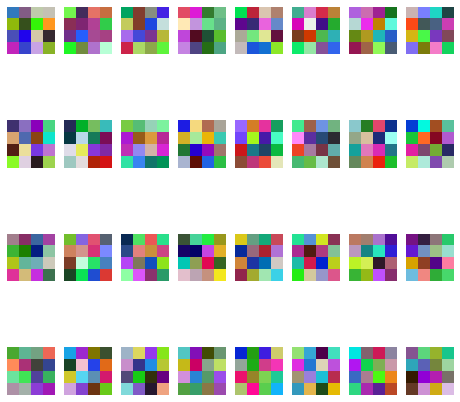

In [31]:
with torch.no_grad():
    conv1_weights = model_state_dict['conv1.weight']
    fig, axs = plt.subplots(4, 8, figsize=(8, 8))
    filters = []
    for filter_index in range(conv1_weights.shape[0]):
        row_index = filter_index // 8
        col_index = filter_index % 8
        
#         idx = np.random.choice(conv1_weights.shape[1],3)
#         print(idx)
        filter = conv1_weights[filter_index,:,:,:]
        filter_image = filter.permute(1, 2, 0).cpu()
        scale = np.abs(filter_image).max()
        scaled_image = filter_image / (2 * scale) + 0.5
        filters.append(scaled_image.cpu())
        axs[row_index, col_index].imshow(scaled_image.cpu())
        axs[row_index, col_index].axis('off')
    plt.show()